# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [6]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

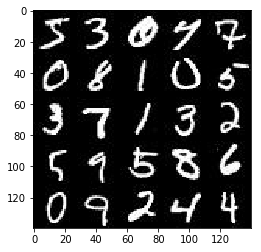

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

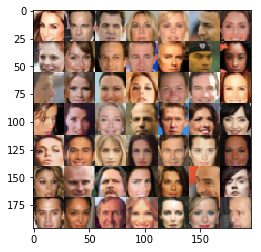

In [10]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


D:\OUTROS\Conda\envs\yolo\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [12]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels), name='input_images')
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_data')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [17]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #conv1
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        conv1 = tf.maximum(alpha*conv1, conv1)
        #conv2
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2)
        #conv3
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3)
        #output
        flat   = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate=0.5)
        
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        #fully connected
        fully = tf.layers.dense(z, 2*2*512)
        fully = tf.reshape(fully, (-1, 2, 2, 512))
        fully = tf.maximum(alpha * fully, fully)
        #conv1
        conv1 = tf.layers.conv2d_transpose(fully, 256, 5, strides=2, padding='VALID')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        #conv2
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding='SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        #output
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding='SAME')
        output = tf.tanh(logits)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_model = generator(input_z, out_channel_dim, is_train=True)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real, reuse=False)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)

    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real)))
    
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))

    discriminator_loss = discriminator_loss_real + discriminator_loss_fake

    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_training_operation = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_training_operation = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_training_operation, g_training_operation


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    steps = 0
    show_every = 100
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
            
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4532... Generator Loss: 0.2988
Epoch 1/2... Discriminator Loss: 0.3848... Generator Loss: 16.6156
Epoch 1/2... Discriminator Loss: 1.4501... Generator Loss: 0.2966
Epoch 1/2... Discriminator Loss: 0.1194... Generator Loss: 3.0642
Epoch 1/2... Discriminator Loss: 1.5908... Generator Loss: 11.3056
Epoch 1/2... Discriminator Loss: 1.0141... Generator Loss: 3.4395
Epoch 1/2... Discriminator Loss: 1.6080... Generator Loss: 1.3890
Epoch 1/2... Discriminator Loss: 0.3733... Generator Loss: 4.3586
Epoch 1/2... Discriminator Loss: 0.2353... Generator Loss: 2.3427
Epoch 1/2... Discriminator Loss: 0.1825... Generator Loss: 3.0479


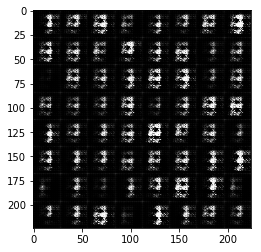

Epoch 1/2... Discriminator Loss: 0.2984... Generator Loss: 1.8814
Epoch 1/2... Discriminator Loss: 0.7936... Generator Loss: 5.0867
Epoch 1/2... Discriminator Loss: 0.3010... Generator Loss: 2.2730
Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 5.7677
Epoch 1/2... Discriminator Loss: 0.6407... Generator Loss: 1.8811
Epoch 1/2... Discriminator Loss: 0.6952... Generator Loss: 1.1337
Epoch 1/2... Discriminator Loss: 0.2477... Generator Loss: 2.1238
Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 2.3696
Epoch 1/2... Discriminator Loss: 0.2311... Generator Loss: 2.4212
Epoch 1/2... Discriminator Loss: 0.5504... Generator Loss: 1.8466


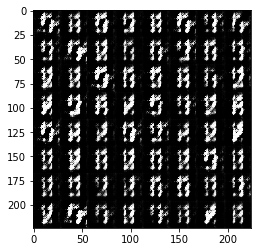

Epoch 1/2... Discriminator Loss: 0.3139... Generator Loss: 4.4554
Epoch 1/2... Discriminator Loss: 0.3267... Generator Loss: 6.2101
Epoch 1/2... Discriminator Loss: 0.2044... Generator Loss: 4.1255
Epoch 1/2... Discriminator Loss: 0.2239... Generator Loss: 4.2846
Epoch 1/2... Discriminator Loss: 0.1339... Generator Loss: 5.6152
Epoch 1/2... Discriminator Loss: 1.0785... Generator Loss: 0.9669
Epoch 1/2... Discriminator Loss: 0.2214... Generator Loss: 3.1175
Epoch 1/2... Discriminator Loss: 0.2072... Generator Loss: 2.7480
Epoch 1/2... Discriminator Loss: 0.2345... Generator Loss: 3.1241
Epoch 1/2... Discriminator Loss: 0.1087... Generator Loss: 3.5558


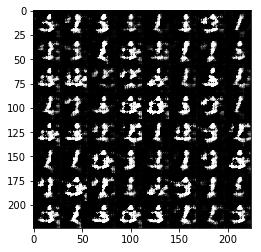

Epoch 1/2... Discriminator Loss: 0.1835... Generator Loss: 3.3863
Epoch 1/2... Discriminator Loss: 0.1077... Generator Loss: 3.4416
Epoch 1/2... Discriminator Loss: 0.5255... Generator Loss: 1.5059
Epoch 1/2... Discriminator Loss: 0.4599... Generator Loss: 3.6693
Epoch 1/2... Discriminator Loss: 0.7819... Generator Loss: 6.9125
Epoch 1/2... Discriminator Loss: 0.2169... Generator Loss: 2.9603
Epoch 1/2... Discriminator Loss: 1.0450... Generator Loss: 0.6208
Epoch 1/2... Discriminator Loss: 0.2942... Generator Loss: 3.6668
Epoch 1/2... Discriminator Loss: 2.3027... Generator Loss: 0.2727
Epoch 1/2... Discriminator Loss: 0.9119... Generator Loss: 0.8008


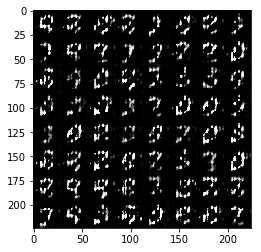

Epoch 1/2... Discriminator Loss: 0.8184... Generator Loss: 3.8878
Epoch 1/2... Discriminator Loss: 0.4601... Generator Loss: 2.0044
Epoch 1/2... Discriminator Loss: 0.5767... Generator Loss: 1.7436
Epoch 1/2... Discriminator Loss: 0.4393... Generator Loss: 1.5572
Epoch 1/2... Discriminator Loss: 0.7388... Generator Loss: 1.0425
Epoch 1/2... Discriminator Loss: 0.7983... Generator Loss: 3.0845
Epoch 1/2... Discriminator Loss: 0.6051... Generator Loss: 2.6090
Epoch 1/2... Discriminator Loss: 0.7680... Generator Loss: 1.3926
Epoch 1/2... Discriminator Loss: 0.6823... Generator Loss: 2.0201
Epoch 1/2... Discriminator Loss: 0.5956... Generator Loss: 2.1639


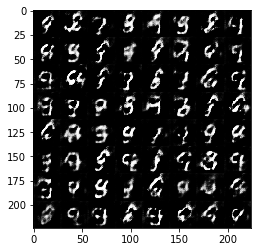

Epoch 1/2... Discriminator Loss: 0.7019... Generator Loss: 2.7294
Epoch 1/2... Discriminator Loss: 0.5527... Generator Loss: 2.2594
Epoch 1/2... Discriminator Loss: 0.4837... Generator Loss: 2.1903
Epoch 1/2... Discriminator Loss: 0.8113... Generator Loss: 1.4744
Epoch 1/2... Discriminator Loss: 0.8868... Generator Loss: 1.3044
Epoch 1/2... Discriminator Loss: 0.8375... Generator Loss: 1.7124
Epoch 1/2... Discriminator Loss: 0.7356... Generator Loss: 1.6891
Epoch 1/2... Discriminator Loss: 0.4697... Generator Loss: 1.6092
Epoch 1/2... Discriminator Loss: 0.8608... Generator Loss: 1.2310
Epoch 1/2... Discriminator Loss: 0.9018... Generator Loss: 1.3581


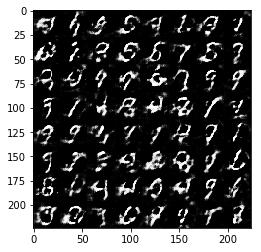

Epoch 1/2... Discriminator Loss: 0.6905... Generator Loss: 1.4663
Epoch 1/2... Discriminator Loss: 0.4861... Generator Loss: 1.9891
Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 0.6973
Epoch 1/2... Discriminator Loss: 0.4928... Generator Loss: 1.9167
Epoch 1/2... Discriminator Loss: 0.5081... Generator Loss: 1.9467
Epoch 1/2... Discriminator Loss: 1.1689... Generator Loss: 3.1551
Epoch 1/2... Discriminator Loss: 0.6166... Generator Loss: 1.7491
Epoch 1/2... Discriminator Loss: 0.9443... Generator Loss: 0.9715
Epoch 1/2... Discriminator Loss: 0.6074... Generator Loss: 2.4209
Epoch 1/2... Discriminator Loss: 0.6422... Generator Loss: 1.7121


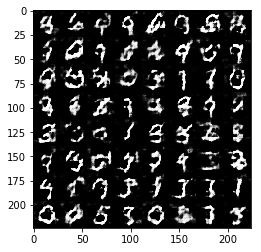

Epoch 1/2... Discriminator Loss: 0.8430... Generator Loss: 1.4194
Epoch 1/2... Discriminator Loss: 0.7308... Generator Loss: 2.1509
Epoch 1/2... Discriminator Loss: 0.7179... Generator Loss: 1.3688
Epoch 1/2... Discriminator Loss: 0.5584... Generator Loss: 1.7807
Epoch 1/2... Discriminator Loss: 0.7319... Generator Loss: 2.5556
Epoch 1/2... Discriminator Loss: 0.5484... Generator Loss: 1.2916
Epoch 1/2... Discriminator Loss: 0.5152... Generator Loss: 1.7204
Epoch 1/2... Discriminator Loss: 0.8670... Generator Loss: 0.9293
Epoch 1/2... Discriminator Loss: 0.7338... Generator Loss: 1.5033
Epoch 1/2... Discriminator Loss: 1.0389... Generator Loss: 0.7496


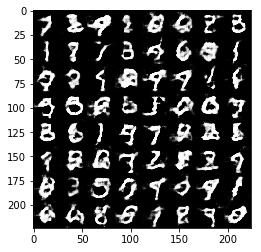

Epoch 1/2... Discriminator Loss: 0.7385... Generator Loss: 1.7271
Epoch 1/2... Discriminator Loss: 0.6171... Generator Loss: 1.7679
Epoch 1/2... Discriminator Loss: 0.8826... Generator Loss: 0.9281
Epoch 1/2... Discriminator Loss: 0.5924... Generator Loss: 1.8627
Epoch 1/2... Discriminator Loss: 0.7148... Generator Loss: 1.5575
Epoch 1/2... Discriminator Loss: 1.2813... Generator Loss: 0.7384
Epoch 1/2... Discriminator Loss: 0.9894... Generator Loss: 1.6778
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 1.8806
Epoch 1/2... Discriminator Loss: 0.6504... Generator Loss: 1.4226
Epoch 1/2... Discriminator Loss: 0.8337... Generator Loss: 1.1664


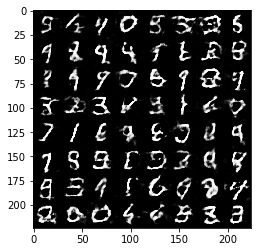

Epoch 1/2... Discriminator Loss: 0.7454... Generator Loss: 1.2731
Epoch 1/2... Discriminator Loss: 0.8714... Generator Loss: 0.8911
Epoch 1/2... Discriminator Loss: 0.7117... Generator Loss: 1.1868
Epoch 2/2... Discriminator Loss: 0.7740... Generator Loss: 1.1872
Epoch 2/2... Discriminator Loss: 0.6396... Generator Loss: 1.7974
Epoch 2/2... Discriminator Loss: 0.7914... Generator Loss: 0.9976
Epoch 2/2... Discriminator Loss: 0.9319... Generator Loss: 0.8490
Epoch 2/2... Discriminator Loss: 1.0128... Generator Loss: 0.7987
Epoch 2/2... Discriminator Loss: 0.8326... Generator Loss: 0.9697
Epoch 2/2... Discriminator Loss: 0.9435... Generator Loss: 0.7821


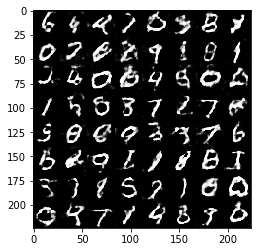

Epoch 2/2... Discriminator Loss: 0.9683... Generator Loss: 0.8227
Epoch 2/2... Discriminator Loss: 0.7037... Generator Loss: 1.6671
Epoch 2/2... Discriminator Loss: 0.6129... Generator Loss: 1.3386
Epoch 2/2... Discriminator Loss: 0.9475... Generator Loss: 0.8481
Epoch 2/2... Discriminator Loss: 0.7107... Generator Loss: 1.1422
Epoch 2/2... Discriminator Loss: 0.8432... Generator Loss: 0.9420
Epoch 2/2... Discriminator Loss: 0.7270... Generator Loss: 1.1331
Epoch 2/2... Discriminator Loss: 0.8494... Generator Loss: 1.2451
Epoch 2/2... Discriminator Loss: 1.1834... Generator Loss: 3.2828
Epoch 2/2... Discriminator Loss: 1.0422... Generator Loss: 0.7421


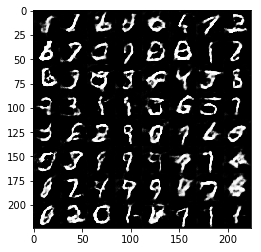

Epoch 2/2... Discriminator Loss: 0.7755... Generator Loss: 1.7702
Epoch 2/2... Discriminator Loss: 0.6925... Generator Loss: 2.1802
Epoch 2/2... Discriminator Loss: 1.1583... Generator Loss: 3.0725
Epoch 2/2... Discriminator Loss: 0.8792... Generator Loss: 2.7419
Epoch 2/2... Discriminator Loss: 1.4349... Generator Loss: 0.3763
Epoch 2/2... Discriminator Loss: 1.1439... Generator Loss: 0.5801
Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 1.5140
Epoch 2/2... Discriminator Loss: 0.7717... Generator Loss: 0.8501
Epoch 2/2... Discriminator Loss: 0.9340... Generator Loss: 0.8843
Epoch 2/2... Discriminator Loss: 0.9004... Generator Loss: 0.8190


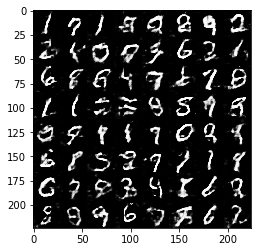

Epoch 2/2... Discriminator Loss: 1.4777... Generator Loss: 0.3655
Epoch 2/2... Discriminator Loss: 0.7179... Generator Loss: 1.0296
Epoch 2/2... Discriminator Loss: 0.7818... Generator Loss: 0.9482
Epoch 2/2... Discriminator Loss: 1.0318... Generator Loss: 0.7101
Epoch 2/2... Discriminator Loss: 0.6861... Generator Loss: 1.6700
Epoch 2/2... Discriminator Loss: 0.7202... Generator Loss: 1.3365
Epoch 2/2... Discriminator Loss: 1.0616... Generator Loss: 0.6275
Epoch 2/2... Discriminator Loss: 0.8689... Generator Loss: 1.2087
Epoch 2/2... Discriminator Loss: 0.7281... Generator Loss: 1.4399
Epoch 2/2... Discriminator Loss: 0.7265... Generator Loss: 2.3441


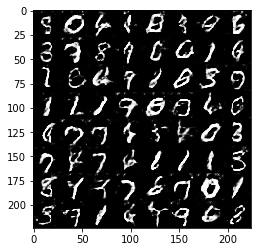

Epoch 2/2... Discriminator Loss: 0.7132... Generator Loss: 1.8224
Epoch 2/2... Discriminator Loss: 0.8607... Generator Loss: 1.9606
Epoch 2/2... Discriminator Loss: 0.9972... Generator Loss: 0.7480
Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 1.1304
Epoch 2/2... Discriminator Loss: 1.3939... Generator Loss: 0.4468
Epoch 2/2... Discriminator Loss: 1.0516... Generator Loss: 0.8742
Epoch 2/2... Discriminator Loss: 0.5560... Generator Loss: 1.3504
Epoch 2/2... Discriminator Loss: 0.8707... Generator Loss: 0.7505
Epoch 2/2... Discriminator Loss: 0.6046... Generator Loss: 2.0496
Epoch 2/2... Discriminator Loss: 0.5788... Generator Loss: 1.6482


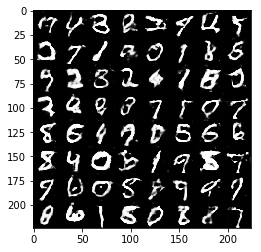

Epoch 2/2... Discriminator Loss: 0.7564... Generator Loss: 1.6228
Epoch 2/2... Discriminator Loss: 0.7825... Generator Loss: 0.9491
Epoch 2/2... Discriminator Loss: 0.9731... Generator Loss: 0.7145
Epoch 2/2... Discriminator Loss: 0.7593... Generator Loss: 0.8529
Epoch 2/2... Discriminator Loss: 4.6729... Generator Loss: 0.0198
Epoch 2/2... Discriminator Loss: 0.7971... Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 0.7537... Generator Loss: 0.9106
Epoch 2/2... Discriminator Loss: 0.6162... Generator Loss: 1.2923
Epoch 2/2... Discriminator Loss: 0.7786... Generator Loss: 0.8787
Epoch 2/2... Discriminator Loss: 0.7778... Generator Loss: 0.9865


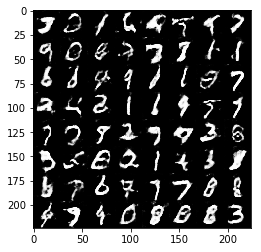

Epoch 2/2... Discriminator Loss: 1.6120... Generator Loss: 0.3878
Epoch 2/2... Discriminator Loss: 0.5789... Generator Loss: 1.3430
Epoch 2/2... Discriminator Loss: 0.4903... Generator Loss: 1.6377
Epoch 2/2... Discriminator Loss: 0.6823... Generator Loss: 1.1077
Epoch 2/2... Discriminator Loss: 0.6793... Generator Loss: 1.0482
Epoch 2/2... Discriminator Loss: 0.7103... Generator Loss: 1.0776
Epoch 2/2... Discriminator Loss: 0.7730... Generator Loss: 1.1281
Epoch 2/2... Discriminator Loss: 0.7243... Generator Loss: 0.9278
Epoch 2/2... Discriminator Loss: 0.7968... Generator Loss: 1.7590
Epoch 2/2... Discriminator Loss: 0.6681... Generator Loss: 1.0078


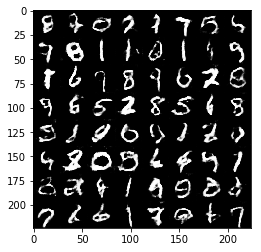

Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 1.9066
Epoch 2/2... Discriminator Loss: 1.0511... Generator Loss: 2.1938
Epoch 2/2... Discriminator Loss: 0.7765... Generator Loss: 1.0197
Epoch 2/2... Discriminator Loss: 1.3259... Generator Loss: 0.4362
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 0.9310
Epoch 2/2... Discriminator Loss: 0.7466... Generator Loss: 1.2252
Epoch 2/2... Discriminator Loss: 1.0291... Generator Loss: 0.6698
Epoch 2/2... Discriminator Loss: 0.5235... Generator Loss: 1.5163
Epoch 2/2... Discriminator Loss: 1.3211... Generator Loss: 0.4278
Epoch 2/2... Discriminator Loss: 0.9204... Generator Loss: 0.7080


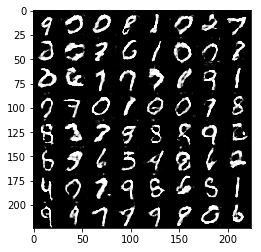

Epoch 2/2... Discriminator Loss: 0.6550... Generator Loss: 1.3379
Epoch 2/2... Discriminator Loss: 0.7281... Generator Loss: 1.2405
Epoch 2/2... Discriminator Loss: 1.2691... Generator Loss: 0.4422
Epoch 2/2... Discriminator Loss: 0.8370... Generator Loss: 0.9906
Epoch 2/2... Discriminator Loss: 0.9249... Generator Loss: 1.0621
Epoch 2/2... Discriminator Loss: 0.5486... Generator Loss: 1.9593
Epoch 2/2... Discriminator Loss: 0.8796... Generator Loss: 0.8476
Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 0.6449
Epoch 2/2... Discriminator Loss: 0.4842... Generator Loss: 2.0259
Epoch 2/2... Discriminator Loss: 1.0837... Generator Loss: 0.8122


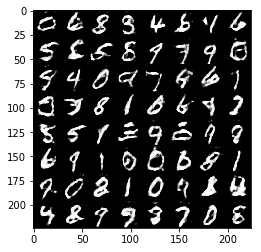

Epoch 2/2... Discriminator Loss: 0.9409... Generator Loss: 0.9058
Epoch 2/2... Discriminator Loss: 0.8179... Generator Loss: 1.2553
Epoch 2/2... Discriminator Loss: 0.9235... Generator Loss: 0.9303
Epoch 2/2... Discriminator Loss: 0.9973... Generator Loss: 0.7689
Epoch 2/2... Discriminator Loss: 0.7615... Generator Loss: 1.6269
Epoch 2/2... Discriminator Loss: 0.7587... Generator Loss: 1.0122
Epoch 2/2... Discriminator Loss: 0.9297... Generator Loss: 0.7151


In [27]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.3935... Generator Loss: 0.0023
Epoch 1/1... Discriminator Loss: 0.1734... Generator Loss: 8.4248
Epoch 1/1... Discriminator Loss: 0.0469... Generator Loss: 8.8416
Epoch 1/1... Discriminator Loss: 0.1453... Generator Loss: 7.6601
Epoch 1/1... Discriminator Loss: 0.2515... Generator Loss: 2.0261
Epoch 1/1... Discriminator Loss: 0.2753... Generator Loss: 12.1057
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 5.4889
Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 0.2345... Generator Loss: 6.5398
Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 2.6764


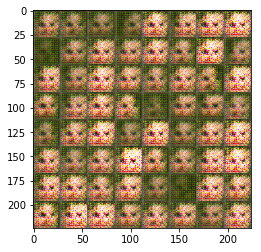

Epoch 1/1... Discriminator Loss: 0.4780... Generator Loss: 1.4040
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 1.7658
Epoch 1/1... Discriminator Loss: 0.1980... Generator Loss: 2.6881
Epoch 1/1... Discriminator Loss: 0.6218... Generator Loss: 1.2281
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 0.5497... Generator Loss: 1.7530
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.5681


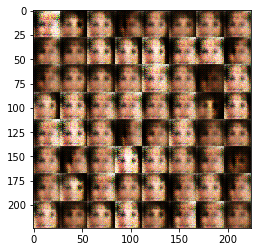

Epoch 1/1... Discriminator Loss: 1.7377... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 2.1015
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 1.6665
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 1.2945
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 1.0929
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 1.1857


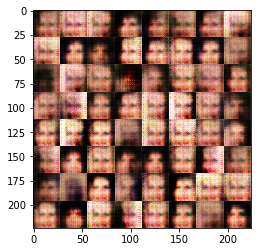

Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.3409
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 1.4232
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 1.7280
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 1.0965


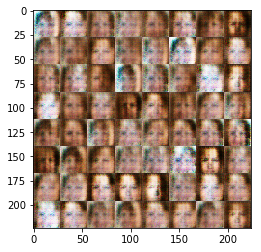

Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 1.7817
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 1.5293
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.7287


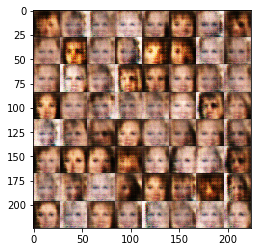

Epoch 1/1... Discriminator Loss: 0.7966... Generator Loss: 1.1299
Epoch 1/1... Discriminator Loss: 0.5315... Generator Loss: 1.5666
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 1.8222
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.6872
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.2163


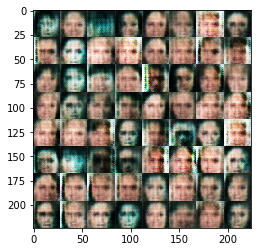

Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.4578
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.0311
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.3591
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 1.0511


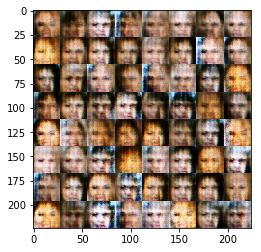

Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 1.2739
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.5750
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 1.2817
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.4738
Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 1.0955
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.3462
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 2.5468
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 0.9739


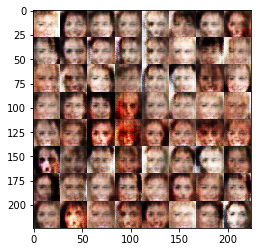

Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 1.5670
Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 1.3617
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.5069
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.4419
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 1.9716
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 1.3054
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.7691


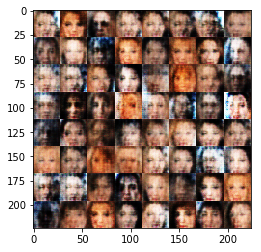

Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 1.2448
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 1.3418
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.2311
Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 0.3518
Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 1.2538
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.2812


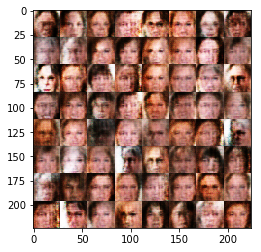

Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 1.1372
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.7725
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.5378
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 1.4883
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.8602... Generator Loss: 0.2722
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.8632


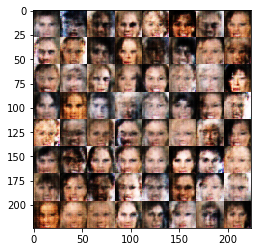

Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 1.1571
Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 1.1338
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.1768
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.5069
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.2192
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 0.8509


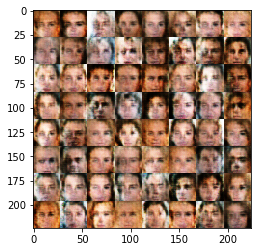

Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.5973... Generator Loss: 0.3205
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.1811
Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 3.0414
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 0.9644


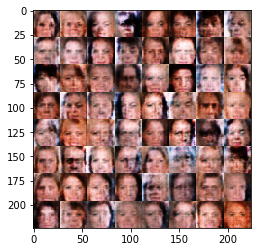

Epoch 1/1... Discriminator Loss: 0.8706... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 1.1279
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 1.0723
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.9704


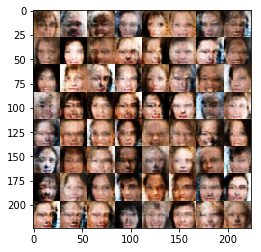

Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.4164
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 1.8346
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.1930
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 1.0570
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.1538
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 1.1919
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 0.7123


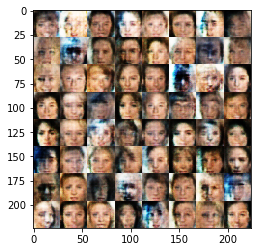

Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 2.1233
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.9723
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 1.8135
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.0959


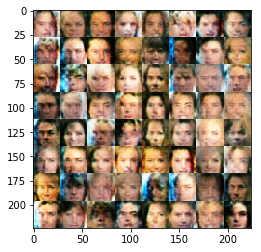

Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.7865
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 1.6780
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 1.1849
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 1.4586
Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.8200... Generator Loss: 0.2652
Epoch 1/1... Discriminator Loss: 1.5604... Generator Loss: 0.4816
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 1.2321


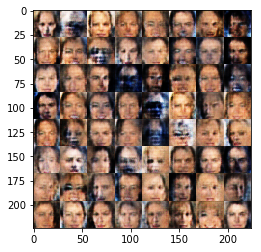

Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 2.0644
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 0.8287... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.3108
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 1.2707
Epoch 1/1... Discriminator Loss: 0.7999... Generator Loss: 1.4245
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 2.1646
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.5216


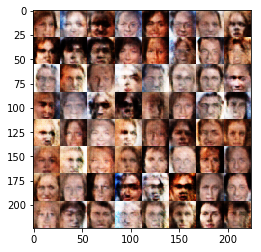

Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 1.2737
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.7572
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.3124
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 1.3644
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 1.4311
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 1.2524


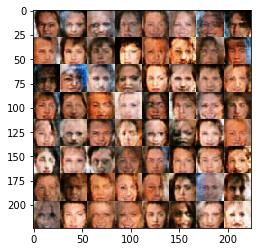

Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 1.3829
Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 1.3761
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 1.2684


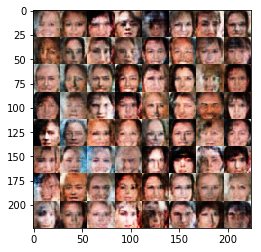

Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 1.6121
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.6798... Generator Loss: 0.2874
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.0447


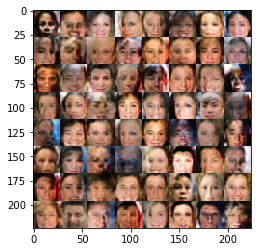

Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 1.3406
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 1.7039
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 0.4173
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 1.0600
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 0.8069


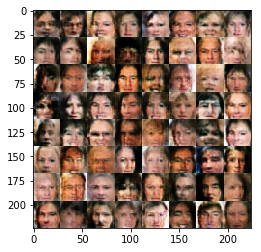

Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 1.0450
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 0.8581... Generator Loss: 1.1024
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 0.9633
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 1.4002
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.5303


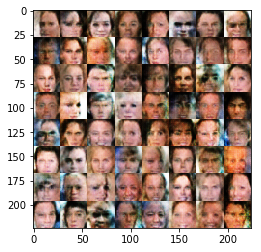

Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 1.1151
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.6707
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 1.1429
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 1.4859
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.4011


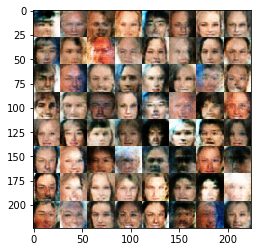

Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 0.8772... Generator Loss: 1.1608
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.1013


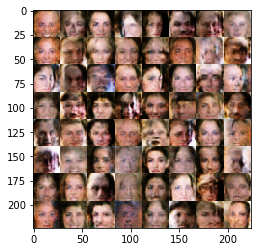

Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 1.2229
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.3094
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.3414
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.6150... Generator Loss: 0.3772


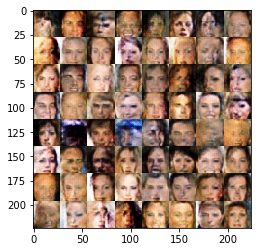

Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.4485
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 0.9096... Generator Loss: 1.1189
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.2367
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.4016
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.1867
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.4853


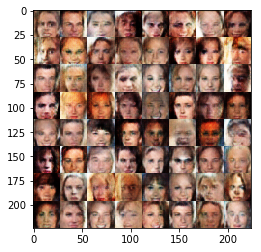

Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.5499
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.1666
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.4474
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 1.4501
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 1.5094
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.7855... Generator Loss: 0.2963
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 1.1058


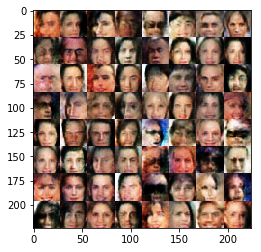

Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 1.1287
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.4629
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.9597


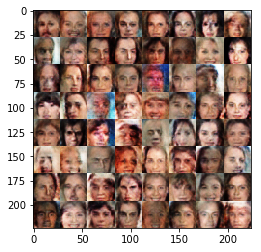

Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 1.8949
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 1.4088
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.6841
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.2897
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 1.6661
Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.7303
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.7409... Generator Loss: 0.2509


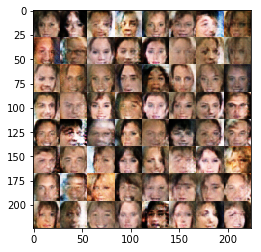

Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.3407
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 1.1853
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.5625


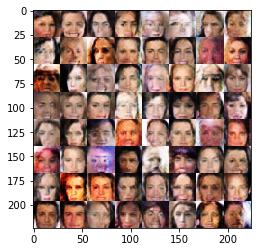

Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 1.7083
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 1.2797
Epoch 1/1... Discriminator Loss: 1.7598... Generator Loss: 0.2563


In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.